#### Импортируем необходимые библиотеки для решения поставленных задач

In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

import requests
from urllib.parse import urlencode



Используем функцию ydisk, для загрузки данных по API.

In [18]:
def ydisk(public_key, sep=None):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    if sep: 
        df = pd.read_csv(download_url, sep=';')
    else:
        df = pd.read_csv(download_url)
    return df

#### Выгружаем данные

In [19]:
df_test = 'https://disk.yandex.ru/d/Wuhqs3MUEMprGw'
df = ydisk(df_test)

In [22]:
df.describe()

,user_cnt,gross
count,1462.000000,1462.000000
mean,6201.270862,516.803010
std,4058.405863,449.168427
min,2085.000000,12.000000
25%,3763.000000,229.000000
50%,4723.000000,418.500000
75%,7253.250000,698.750000
max,41110.000000,8214.000000


In [61]:
df.head(10)

,ms,cohort,user_cnt,gross
0,ORGANIC,2016-01-01,3676,1510
1,UA,2016-01-01,6061,686
2,UA,2016-01-02,6542,1179
3,ORGANIC,2016-01-02,3875,565
4,ORGANIC,2016-01-03,3699,425
...,...,...,...,...
1457,UA,2017-12-29,4180,65
1458,ORGANIC,2017-12-30,5651,17
1459,UA,2017-12-30,4291,13
1460,UA,2017-12-31,3743,25


В нашем случае, имея только суммарное количество трафовых и органических пользователей в день, мы можем сделать лишь косвенные предположения о влиянии трафика на привлечение новых пользователей.

Используем два подхода для оценки влияния "k-фактора":

#### 1. Анализ корреляции:

    * Построим графики изменения количества трафовых пользователей и органических пользователей по дням.
    * Посмотрим, есть ли в графиках видимая корреляция.  
    * Если рост количества трафовых пользователей сопровождается ростом количества органических пользователей, это может говорить о том, что трафик оказывает влияние на привлечение органики.

In [26]:
# Создание новой таблицы с количеством новых пользователей и выручкой по каналам привлечения
new_df = df.pivot_table(index='cohort', columns='ms', values=['user_cnt', 'gross'], aggfunc='sum')
new_df.columns = [f'{col[1]}_{col[0]}' for col in new_df.columns]
new_df.reset_index(inplace=True)
new_df.head()

,cohort,ORGANIC_gross,UA_gross,ORGANIC_user_cnt,UA_user_cnt
0,2016-01-01,1510,686,3676,6061
1,2016-01-02,565,1179,3875,6542
2,2016-01-03,425,1186,3699,6260
3,2016-01-04,1161,718,3237,5330
4,2016-01-05,917,1308,2792,5027


In [190]:
new_df.describe()

,ORGANIC_gross,UA_gross,ORGANIC_user_cnt,UA_user_cnt
count,731.000000,731.000000,731.000000,731.000000
mean,528.759234,504.846785,4707.459644,7695.082079
std,455.184716,443.059257,2152.880856,4884.662254
min,12.000000,13.000000,2326.000000,2085.000000
25%,268.000000,190.000000,3549.000000,4176.500000
50%,456.000000,377.000000,4222.000000,6538.000000
75%,711.000000,673.000000,5186.000000,9643.500000
max,8214.000000,4178.000000,22057.000000,41110.000000


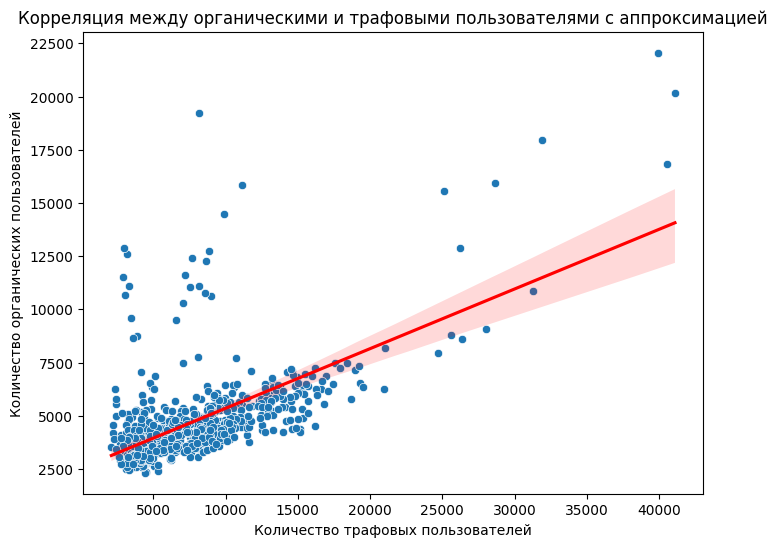

In [47]:
# Построение графика корреляции между ORGANIC_user_cnt и UA_user_cnt
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UA_user_cnt', y='ORGANIC_user_cnt', data=new_df)
sns.regplot(x='UA_user_cnt', y='ORGANIC_user_cnt', data=new_df, scatter=False, color='red')
plt.title('Корреляция между органическими и трафовыми пользователями с аппроксимацией')
plt.ylabel('Количество органических пользователей')
plt.xlabel('Количество трафовых пользователей')
plt.show()

In [34]:
# Вычисление коэффициента корреляции Пирсона
correlation = new_df['ORGANIC_user_cnt'].corr(new_df['UA_user_cnt'])
correlation

0.6356162942958982

В данных присутствуют выбросы, используем более устойчивую к ним меру корреляции, воспользуемся ранговой корреляцией Спирмена 

In [36]:
# Вычисление корреляции Спирмена
spearman_corr = new_df['ORGANIC_user_cnt'].corr(new_df['UA_user_cnt'], method='spearman')
print(f'Корреляция Спирмена между ORGANIC_user_cnt и UA_user_cnt: {spearman_corr}')

Корреляция Спирмена между ORGANIC_user_cnt и UA_user_cnt: 0.6429175078365315


#### Вывод:
Значение коэффициента корреляции Спирмена = 0.643, указывает на наличие положительной монотонной связи между количеством органических пользователей и трафовых пользователей. 

Таким образом, рост трафовых пользователей сопровождается ростом количества органических пользователей, это может говорить о том, что трафик оказывает влияние на привлечение органики. 

Следовательно: подозрение, что часть органики приходит от купленного трафа верна!

#### 2. Сравнение периодов с разным объемом трафика:

    * Выберем периоды с разным объемом трафовых пользователей (например, дни с высокой активностью рекламных кампаний и дни с низкой активностью).
    * Сравним среднее количество органических пользователей в эти периоды.
    * Если в периоды с высоким трафиком среднее количество органических пользователей выше, это может косвенно указывать на влияние трафика на привлечение органики.

In [37]:
new_df.head()

,cohort,ORGANIC_gross,UA_gross,ORGANIC_user_cnt,UA_user_cnt
0,2016-01-01,1510,686,3676,6061
1,2016-01-02,565,1179,3875,6542
2,2016-01-03,425,1186,3699,6260
3,2016-01-04,1161,718,3237,5330
4,2016-01-05,917,1308,2792,5027


In [39]:
# Сортировка таблицы по столбцу 'column_name' по возрастанию
sorted_df = new_df.sort_values(by='UA_user_cnt')

# Выбор 10 верхних строк
top_10 = sorted_df.head(10)

# Выбор 10 нижних строк
bottom_10 = sorted_df.tail(10)

In [44]:
top_10.ORGANIC_user_cnt.mean()

4555.9

In [49]:
top_10.sort_values('cohort')

,cohort,ORGANIC_gross,UA_gross,ORGANIC_user_cnt,UA_user_cnt
361,2016-12-27,1507,208,4991,2413
362,2016-12-28,987,40,4564,2233
363,2016-12-29,902,57,5545,2386
364,2016-12-30,886,62,6271,2339
365,2016-12-31,927,74,5799,2438
368,2017-01-03,643,60,4208,2210
369,2017-01-04,343,356,3933,2297
714,2017-12-15,22,25,3237,2488
715,2017-12-16,85,20,3556,2085
716,2017-12-17,13,25,3455,2431


In [45]:
bottom_10.ORGANIC_user_cnt.mean()

14319.1

In [46]:
bottom_10

,cohort,ORGANIC_gross,UA_gross,ORGANIC_user_cnt,UA_user_cnt
231,2016-08-19,858,500,8789,25624
230,2016-08-18,369,349,12869,26198
232,2016-08-20,733,656,8600,26364
233,2016-08-21,679,480,9055,28012
228,2016-08-16,695,990,15959,28646
223,2016-08-11,516,1175,10872,31311
227,2016-08-15,903,1081,17973,31931
226,2016-08-14,1104,1633,22057,39919
224,2016-08-12,576,1041,16829,40581
225,2016-08-13,1483,1233,20188,41110


#### Вывод:
Среднее значение органического трафика в периоды интенсивной рекламы существенно больше, чем в периоды низкой рекламы, что косвенно указывает на влияние трафика на привлечение органики.

Таким образом, рост трафовых пользователей сопровождается ростом количества органических пользователей, это может говорить о том, что трафик оказывает влияние на привлечение органики.

Следовательно: подозрение, что часть органики приходит от купленного трафа верна!

#### Резюмируя:
Используя два подхода для оценки влияния "k-фактора" мы убедились, что "k-фактор" отличен от 0, найдем приблизительное значение "k-фактора"

Создадим новую таблицу, где будет информация только о  трафике по дням!

In [168]:
data = new_df[['cohort', 'ORGANIC_user_cnt', 'UA_user_cnt']]
data.head()

,cohort,ORGANIC_user_cnt,UA_user_cnt
0,2016-01-01,3676,6061
1,2016-01-02,3875,6542
2,2016-01-03,3699,6260
3,2016-01-04,3237,5330
4,2016-01-05,2792,5027


Для более точного анализа нужно разделить органических пользователей на две группы:

1. Органические пользователи, привлеченные платными: Те, кто пришел благодаря виральности, рекомендациям платных пользователей или другим косвенным эффектам от рекламы.
2. "Чистые" органические пользователи: Те, кто нашел приложение самостоятельно, без какого-либо влияния рекламных кампаний.

#### Проблема: У нас нет возможности точно определить, к какой группе относится каждый органический пользователь.

Проанализируем данные наглядно, построим график динамики органического и трафового пользователя:

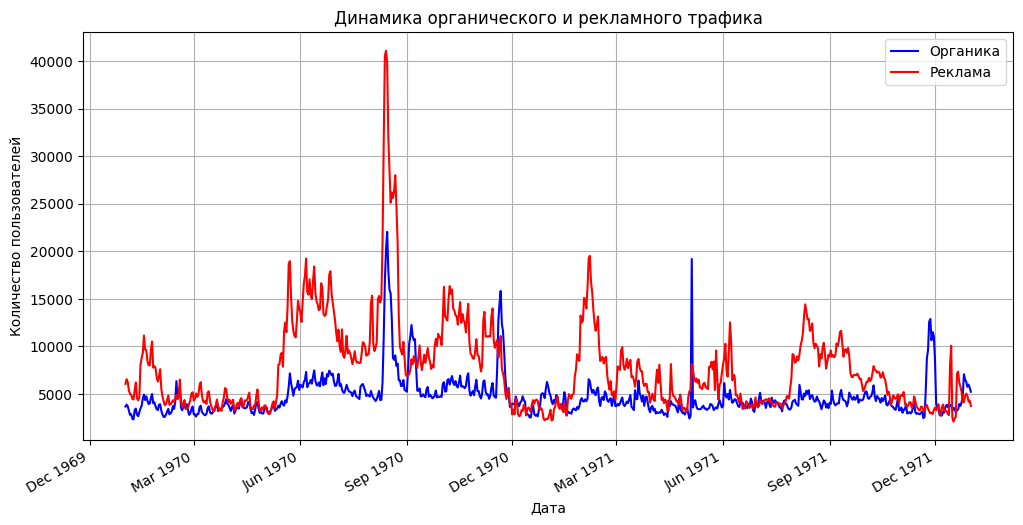

In [174]:
# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(data['cohort'], data['ORGANIC_user_cnt'], label='Органика', color='blue')
plt.plot(data['cohort'], data['UA_user_cnt'], label='Реклама', color='red')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.title('Динамика органического и рекламного трафика')
plt.legend()
plt.grid(True)

# Форматирование оси X: отображение месяца и года
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # Формат: 'Jan 2021'
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Метки каждые 3 месяца
plt.gcf().autofmt_xdate() # Автоматическое форматирование и поворот меток

plt.show()

Пофиксим дневные перепады окном в неделю:

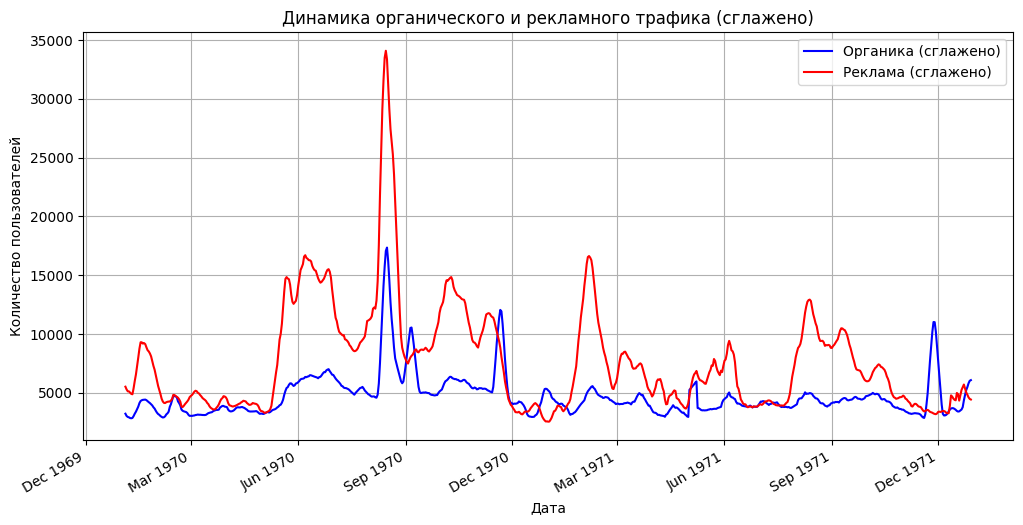

In [172]:
# Сглаживание скользящим средним (окно 7 дней)
data['organic_smoothed'] = data['ORGANIC_user_cnt'].rolling(window=7, center=True).mean()
data['paid_smoothed'] = data['UA_user_cnt'].rolling(window=7, center=True).mean()

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(data['cohort'], data['organic_smoothed'], label='Органика (сглажено)', color='blue')
plt.plot(data['cohort'], data['paid_smoothed'], label='Реклама (сглажено)', color='red')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.title('Динамика органического и рекламного трафика (сглажено)')
plt.legend()
plt.grid(True)

# Форматирование оси X: отображение месяца и года
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # Формат: 'Jan 2021'
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Метки каждые 3 месяца
plt.gcf().autofmt_xdate() # Автоматическое форматирование и поворот меток

plt.show()


Вывод: анализ динамики органического и трафового пользователя показал, что есть взаимосвязь динамики трафовых пользователей на динамику органических -- при уменьшении/увеличении трафовых пользователей происходит уменьшение/увеличение органических пользователей.

#### Резюмируя: 
Анализ взаимосвязи трафового пользователя на органического показал нам корреляцию в 0.64, так же при помощи графика -- анализа динамики пользователей показал, что есть существенная взаимосвязь.

Таким образом: чтобы вычислить приблизительный k-фактор можно расчитать дельту органики и трафовых пользователей и уже из этих данных получить k-фактор.

Отсечем самые маленькие изменения, так как именно они, скорее всего, представляют собой случайные флуктуации и могут искажать расчёт k-фактора. 

Установим threshold равный 5-му квантилю, чтобы оставить 95% самых существенных изменений в рекламе.

In [188]:
# 1. Рассчитываем ежедневные изменения
data['delta_organic'] = data['ORGANIC_user_cnt'].diff()
data['delta_paid'] = data['UA_user_cnt'].diff()

# 2. Фильтруем данные 
threshold = data_clean['delta_paid'].abs().quantile(0.05) # Порог значительного изменения UA 
filtered_data = data[abs(data['delta_paid']) > threshold]

# 3. Рассчитываем отношение
filtered_data['k_factor'] = filtered_data['delta_organic'] / filtered_data['delta_paid']

# 4. Усредняем результаты
average_k_factor = filtered_data['k_factor'].mean()

print(f"Средний k-фактор: {average_k_factor:.2f}")


Средний k-фактор: 0.41


C:\Users\Дима\AppData\Local\Temp\ipykernel_9324\2441351539.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['k_factor'] = filtered_data['delta_organic'] / filtered_data['delta_paid']


Для учета влияния линии тренда на количество органических пользователей, используем подход декомпозиции:
* Используем библиотеку `statsmodels`: С помощью функции `seasonal_decompose` можно разложить временной ряд на трендовую, сезонную и остаточную компоненты.
* Вычитаем тренд: Из исходного ряда органических пользователей вычитаем трендовую компоненту.
* Используем "очищенные" данные: Далее работаем с рядом, очищенным от тренда.

In [189]:
data_clean = new_df[['cohort', 'ORGANIC_user_cnt', 'UA_user_cnt']]

# Декомпозиция ряда ORGANIC_user_cnt
result = seasonal_decompose(data_clean['ORGANIC_user_cnt'], model='additive', period=7) 

# Вычитаем тренд 
data_clean['organic_detrended'] = data_clean['ORGANIC_user_cnt'] - result.trend

# Рассчитываем ежедневные изменения
data_clean['delta_organic'] = data_clean['organic_detrended'].diff()
data_clean['delta_paid'] = data_clean['UA_user_cnt'].diff()

# Фильтруем данные 
threshold = data_clean['delta_paid'].abs().quantile(0.05) # Порог значительного изменения UA
filtered_data = data_clean[abs(data_clean['delta_paid']) > threshold]

# Рассчитываем отношение
filtered_data['k_factor'] = filtered_data['delta_organic'] / filtered_data['delta_paid']

# Усредняем результаты
average_k_factor = filtered_data['k_factor'].mean()

print(f"Средний k-фактор: {average_k_factor:.2f}")


Средний k-фактор: 0.37


C:\Users\Дима\AppData\Local\Temp\ipykernel_9324\4269424505.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['organic_detrended'] = data_clean['ORGANIC_user_cnt'] - result.trend
C:\Users\Дима\AppData\Local\Temp\ipykernel_9324\4269424505.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['k_factor'] = filtered_data['delta_organic'] / filtered_data['delta_paid']


Теперь расчет k-фактора будет учитывать влияние тренда на количество органических пользователей.

#### Задача 1: посчитать k-фактор от трафовых пользователей
k-фактор = 0.37